# Import Packages

In [2]:
import pandas as pd
import pyaudio
import numpy as np
from IPython import display
import os
from sklearn.preprocessing import normalize
import datetime

In [3]:
from pynput import keyboard
import wave

In [4]:
# Should see a default device, otherwise will get an error below
pa = pyaudio.PyAudio()
pa.get_default_input_device_info()

{'defaultHighInputLatency': 0.18,
 'defaultHighOutputLatency': 0.18,
 'defaultLowInputLatency': 0.09,
 'defaultLowOutputLatency': 0.09,
 'defaultSampleRate': 44100.0,
 'hostApi': 0,
 'index': 1,
 'maxInputChannels': 2,
 'maxOutputChannels': 0,
 'name': 'Microphone (Logitech USB Microp',
 'structVersion': 2}

# Testing

In [5]:
# I want to record for approximately 200ms for each keypress. This recording should center on the press event.
# <---100ms---> KeyPress <---100ms--->
chunk = 1024
f = pyaudio.paInt16 # Format
rate = 44100
record_msec = 25

row_size = int(rate / chunk * record_msec * (1/1000))

p = pyaudio.PyAudio()
stream = p.open(format = f, channels = 1, rate = rate, input = True, frames_per_buffer = chunk)

frames = []
df_list = []

In [1]:
import threading
from time import sleep

In [7]:
import queue
q = queue.Queue() # Use Queue as FIFO for recorded frames

In [8]:
def worker():
    while True:
        data = stream.read(chunk * row_size) # Raw data in byte format
        q.put(data)
        #frames.append(data)

        if q.qsize() > 8:
            q.get()
        #data_int = np.frombuffer(data, dtype=np.int16) # convert to int16

    # Create dictionary for each sample and add to list (used later to )
    #sample = [{'key': key, 'data': data_int, 'raw': data, 'timestamp': datetime.datetime.utcnow()}]
    #self.df_list.extend(sample)
    return

In [9]:
def on_press(key):
    print(key)
    # Escape Pressed
    if key == keyboard.Key.esc:
        stream.stop_stream()
        stream.close()
        p.terminate()
        return False
    else:
        sleep(0.05)
        frames = list(q.queue)
        waveFile = wave.open("test.wav", 'wb')
        waveFile.setnchannels(1)
        waveFile.setsampwidth(p.get_sample_size(f))
        waveFile.setframerate(rate)
        waveFile.writeframes(b''.join(frames))
        waveFile.close() 

threads = []
t = threading.Thread(target=worker)
threads.append(t)
t.start()

with keyboard.Listener(on_press=on_press) as listener:
    listener.join()

Key.space
'H'
Key.space
'M'
'I'
Key.down
Key.enter
Key.ctrl_l
'F'
'T'
'I'
'M'
'E'
Key.enter
'I'
'M'
'P'
'O'
'R'
'T'
Key.space
'T'
'I'
'M'
'E'
'F'
'R'
'O'
'M'
Key.space
'T'
'I'
'M'
'E'
Key.space
'I'
'M'
'P'
'O'
'R'
'T'
Key.space
'S'
'L'
'E'
'E'
'P'
Key.esc


### On keypress, record microphone
### On keyrelease, save data

In [6]:
class KeyAudio(object):
    def __init__(self):
        print("Instantiating...")
        
        self.chunk = 1024
        self.format = pyaudio.paInt16
        self.channels = 1
        self.rate = 44100
        #self.record_seconds = 1
        self.record_msec = 100
        self.sample_size = int(self.rate*float(self.record_msec/1000.))
        
        self.row_size = int(self.rate / self.chunk * self.record_msec * (1/1000))
        
        self.p = pyaudio.PyAudio()
        self.stream = self.p.open(format = self.format, 
        channels = self.channels,
        rate = self.rate,
        input = True, 
        frames_per_buffer = self.chunk)
        
        self.data = self.stream.read(self.chunk)
        self.frames = []
        self.df_list = []
    
    def startListener(self):
        print("Starting listener...")
        
        with keyboard.Listener(
                on_press=self.on_press,
                on_release=self.on_release) as listener:
            listener.join()
        
    def stopListener(self):
        pynput.keyboard.Listener.stop
        
    def on_press(self, key):
        if key != keyboard.Key.esc:
            self.log(key)
            
    def on_release(self, key): 
        if key == keyboard.Key.esc:
            self.save_dataframe()
            # Stop listener
            return False
        else:
            pass
            
    def log(self, key):
        # Multiplying by row_size gives me the number of chunks necessary to record for record_msec defined on init
        data = self.stream.read(self.chunk * self.row_size) # Raw data in byte format
        data_int = np.frombuffer(data, dtype=np.int16) # convert to int16

        # Create dictionary for each sample and add to list (used later to )
        sample = [{'key': key, 'data': data_int, 'raw': data, 'timestamp': datetime.datetime.utcnow()}]
        self.df_list.extend(sample)
        
    def get_dataframe(self):
        return self.df_list
    
    def normalize_data(data):
        _max = max([np.max(r) for r in data])
        _min = min([np.min(r) for r in data])
        normalized = [(r - _min)/(_max - _min) for r in data]
        return normalized
    
    def save_data_as_wav(self, data, filename="file.wav"):
        WAVE_OUTPUT_FILENAME = filename
        waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb') # 'wb' write only mode
        waveFile.setnchannels(self.channels)
        waveFile.setsampwidth(self.p.get_sample_size(self.format))
        waveFile.setframerate(self.rate)
        waveFile.writeframes(data)
        waveFile.close()
        
    def save_dataframe(self, filename='DataSet/data.pkl'):
        df = pd.DataFrame.from_records(self.get_dataframe())
        
        # Get existing data and combine with new data
        if os.path.isfile(filename):
            df_saved = pd.read_pickle(filename)
            df = df_saved.append(df, ignore_index=True)
            
        # Save to pickle file
        df.to_pickle(filename)

# Data Sampling
#### Hit Esc to stop sampling

In [8]:
key = KeyAudio()
key.startListener()

Instantiating...
Starting listener...


# Read saved dataframe

In [9]:
# Read saved list of data from object into a dataframe
df = pd.read_pickle('DataSet/data.pkl')
print(len(df))
df.head()

27770


,data,key,raw,timestamp
0,"[-39, -13, 32, 65, 76, 78, 83, 93, 99, 106, 12...",Key.space,b'\xd9\xff\xf3\xff \x00A\x00L\x00N\x00S\x00]\x...,2017-07-29 14:45:19.750098
1,"[0, -9, -14, -14, -7, 9, 31, 41, 33, 34, 58, 7...",Key.enter,b'\x00\x00\xf7\xff\xf2\xff\xf2\xff\xf9\xff\t\x...,2017-07-29 14:45:20.107083
2,"[-219, -216, -208, -200, -194, -189, -180, -17...",Key.space,b'%\xff(\xff0\xff8\xff>\xffC\xffL\xffV\xffa\xf...,2017-07-29 14:45:20.883910
3,"[20, 14, 12, 16, 27, 36, 38, 31, 12, 1, -7, -5...",Key.enter,b'\x14\x00\x0e\x00\x0c\x00\x10\x00\x1b\x00$\x0...,2017-07-29 14:45:21.252549
4,"[-433, -438, -435, -430, -420, -409, -396, -38...",Key.space,b'O\xfeJ\xfeM\xfeR\xfe\\\xfeg\xfet\xfe\x80\xfe...,2017-07-29 14:45:21.828184


# Plot Data Row

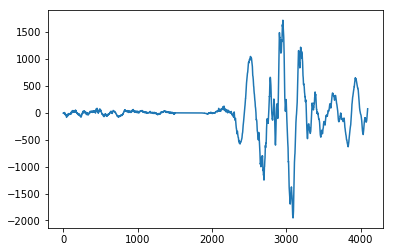

In [347]:
import matplotlib.pyplot as plt
plt.plot(df['data'][300])
plt.show()

# Save as WAV

In [102]:
key.save_data_as_wav(df['data'][0])